# MicroTask 1

### Produce a listing of the number of new committers per month, and the number of commits for each of them, as a table and as a CSV file. Use the GrimoireLab enriched index for git.

In [49]:
#Importing Libraries 
from datetime import datetime
import elasticsearch
import elasticsearch_dsl
from pprint import pprint
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
from perceval.backends.core.git import Git


In [50]:
# Url for the git repo to analyze
repo_url = 'http://github.com/grimoirelab/perceval.git'

# Directory for letting Perceval clone the git repo
repo_dir = '/tmp/perceval.git'

# ElasticSearch instance (url)
# Assuming your localhost instance is ON , if not initialize it
es = elasticsearch.Elasticsearch('http://localhost:9200/',  verify_certs=False)

enrich_index_name = 'git'


### Deleting any previous instance of the index ( if they exist ) and creating new one

In [9]:
# Create the 'git' index in ElasticSearch
try:
    es.indices.create(enrich_index_name)
except elasticsearch.exceptions.RequestError:
    print("deleting")
    #This will delete the already existing "enrich_index_name" and will create a new one
    es.indices.delete(enrich_index_name)
    es.indices.create(enrich_index_name)

repo = Git(uri=repo_url, gitpath=repo_dir)
for commit in repo.fetch():
    # Upload the whole body to ElasticSearch .
    es.index(index='git', doc_type='summary', body=commit)


PUT http://localhost:9200/git [status:400 request:0.004s]


deleting


In [105]:
response = es.search(index=enrich_index_name)
Number_of_commits = response['hits']['total']
print("Total Number of commits :- %s" %(Number_of_commits))
response = es.search( index=enrich_index_name , body={"size":Number_of_commits} )

author=[] #declaring a list
output = set() # set funtion in python chooses unique strings


Total Number of commits :- 1136


In [106]:
for i in response['hits']['hits']:
    output.add(i['_source']['data']['Author']) #will add only unique strings to the list

for i in output:
    dictionary = {'Author_Name' : i , 'First_Commit_Date' : datetime.now() , 'Total_Number_of_commits' : 0}
    author.append(dictionary)

# author

In [107]:
for i in response['hits']['hits']:
    for j in author:
        if j['Author_Name'] == i['_source']['data']['Author'] :
            temp = i['_source']['data']['AuthorDate']
            temp = datetime.strptime(temp, '%a %b %d %H:%M:%S %Y %z').strftime('%a %b %d %H:%M:%S %Y')
            temp = datetime.strptime(temp, '%a %b %d %H:%M:%S %Y')
            if(j['First_Commit_Date'] > temp):
                j['First_Commit_Date'] = temp
    
            j['Total_Number_of_commits']=j['Total_Number_of_commits']+1
        
for i in author:
#     print(str(i['First_Commit_Date'].year) +'-' + str(i['First_Commit_Date'].month))
#     print(i['First_Commit_Date'].strftime('%Y-%m'))
        
    i['First_Commit_Date'] = i['First_Commit_Date'].strftime('%Y-%m')
    
# author


First-Commit-Date :- 2015-08 
Last-Commit-Date  :- 2018-03


,Author_Name,First_Commit_Date,Total_Number_of_commits
1,Santiago Dueñas <sduenas@bitergia.com>,2015-08,731
2,Alvaro del Castillo <acs@bitergia.com>,2015-12,47
3,Jesus M. Gonzalez-Barahona <jgb@gsyc.es>,2015-12,18
4,Alberto Martín <alberto.martin@bitergia.com>,2016-02,51
5,J. Manrique Lopez de la Fuente <jsmanrique@bit...,2016-03,1
6,camillem <camillem@users.noreply.github.com>,2016-03,2
7,quan <zhquan7@gmail.com>,2016-04,5
8,Luis Cañas Díaz <lcanas@bitergia.com>,2016-09,1
9,Stephan Barth <stephan.barth@gmail.com>,2017-01,1
10,valerio cosentino <valcos@bitergia.com>,2017-09,6


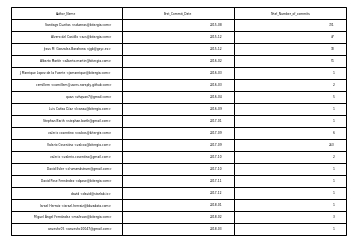

In [108]:
s = pd.DataFrame(author)
# s['First_Commit_Date'] = pd.to_datetime(s.First_Commit_Date)
s.sort_values(by = 'First_Commit_Date' , inplace=True)
s.index = range(1,len(s.index)+1)
# pprint(len(s.index))
# pprint(s.First_Commit_Date[len(s.index)])
temp1 = s.First_Commit_Date[1] #stores the first ever commit made on the repo
temp2 = s.First_Commit_Date[len(s.index)] #stores the latest commit made on the repo
print("First-Commit-Date :- %s \nLast-Commit-Date  :- %s" %(temp1,temp2)) # printing the first and last commit date on the repo


s.to_csv('author_number_of_commits.csv')

#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, s,rowLabels=['']*s.shape[0], loc='center')
plt.savefig('author_number_of_commits.png' , bbox_inches = 'tight')
s

In [109]:
#https://stackoverflow.com/questions/46741423/add-months-to-a-date-in-pandas
#Above link on how to add the last month to a date
month_commit = pd.date_range(*(pd.to_datetime([temp1, temp2]) + pd.offsets.MonthEnd()), freq='M')
# pprint(month_commit)
month_commit = [i.strftime('%Y-%m') for i in month_commit]
# pprint(month_commit)

commiters_per_month = dict() #or commiters_per_month = [] #will check the number of "new author commits" occured during each month
temp = []
for i in month_commit:
    commiters_per_month[i]=0
# pprint(commiters_per_month)

for i in author:
    commiters_per_month[i['First_Commit_Date']]+=1

# pprint(commiters_per_month)    

In [110]:
#pd.DataFrame(commiters_per_month.items()) in python version < 3 . Check the below link for for more details
#https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
answer = pd.DataFrame(list(commiters_per_month.items()), columns=['year-month' , 'Number_of_Commits'])
answer.sort_values(by = 'year-month' , inplace=True)
answer.index = range(1,len(answer.index)+1)
# print(answer)


,year-month,Number_of_Commits
1,2015-08,1
2,2015-09,0
3,2015-10,0
4,2015-11,0
5,2015-12,2
6,2016-01,0
7,2016-02,1
8,2016-03,2
9,2016-04,1
10,2016-05,0


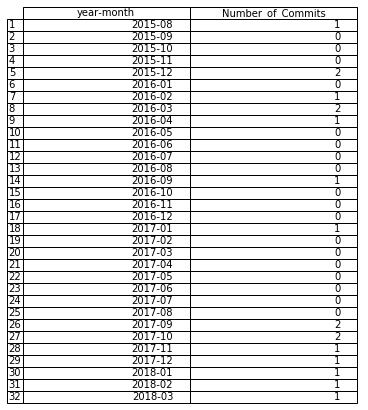

In [111]:
answer.to_csv('authors_per_month.csv')

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis


table(ax,answer , loc='center' )
plt.savefig('authors_per_month.png' , bbox_inches = 'tight' )
answer